# Credit Card Fraud Detection

### Importing the necessary libraries

In [72]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import missingno as msno
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_bar
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import seaborn as sns
import category_encoders as ce
from sklearn.metrics import recall_score
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score,f1_score, roc_auc_score, roc_curve

### Reading the datasets

In [73]:
data = pd.read_excel("data.xls")
data.head()

,KEY,VAR_TARGET,VAR_1,VAR_2,VAR_3,VAR_4,VAR_5,VAR_6,VAR_7,VAR_8,...,VAR_41,VAR_42,VAR_43,VAR_44,VAR_45,VAR_46,VAR_47,VAR_48,VAR_49,VAR_50
0,1,0,6603,W,34.0,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,1300,NaN
1,2,1,5210,I,34.0,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,NaN,0.0,0.0,NaN,0.0,NaN,1570,1800.0
2,3,1,2505,Q,7.0,NaN,NaN,0.0,1000.0,915.0,...,269.0,1004.0,NaN,1000.0,1000.0,1560.0,553.0,1567.0,1450,1450.0
3,4,1,3902,Q,34.0,NaN,NaN,0.0,1000.0,722.0,...,30.0,16.0,NaN,1000.0,1000.0,1301.0,17.0,1301.0,2000,2000.0
4,5,1,4607,Q,34.0,11187.0,11187.0,1.0,27187.0,5436.0,...,74.0,38.0,NaN,13594.0,16000.0,1518.0,19.0,1389.0,1700,1700.0


In [74]:
data.shape

(5626, 52)

In [75]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5626 entries, 0 to 5625
Data columns (total 52 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   KEY         5626 non-null   int64  
 1   VAR_TARGET  5626 non-null   int64  
 2   VAR_1       5626 non-null   int64  
 3   VAR_2       5626 non-null   object 
 4   VAR_3       5622 non-null   float64
 5   VAR_4       4344 non-null   float64
 6   VAR_5       4344 non-null   float64
 7   VAR_6       5612 non-null   float64
 8   VAR_7       5612 non-null   float64
 9   VAR_8       5612 non-null   float64
 10  VAR_9       5612 non-null   float64
 11  VAR_10      5612 non-null   float64
 12  VAR_11      5316 non-null   float64
 13  VAR_12      5626 non-null   int64  
 14  VAR_13      4528 non-null   float64
 15  VAR_14      4528 non-null   float64
 16  VAR_15      1801 non-null   float64
 17  VAR_16      5598 non-null   object 
 18  VAR_17      5508 non-null   float64
 19  VAR_18      5612 non-null  

C:\Users\lenovo\AppData\Local\Temp/ipykernel_11096/2864627972.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


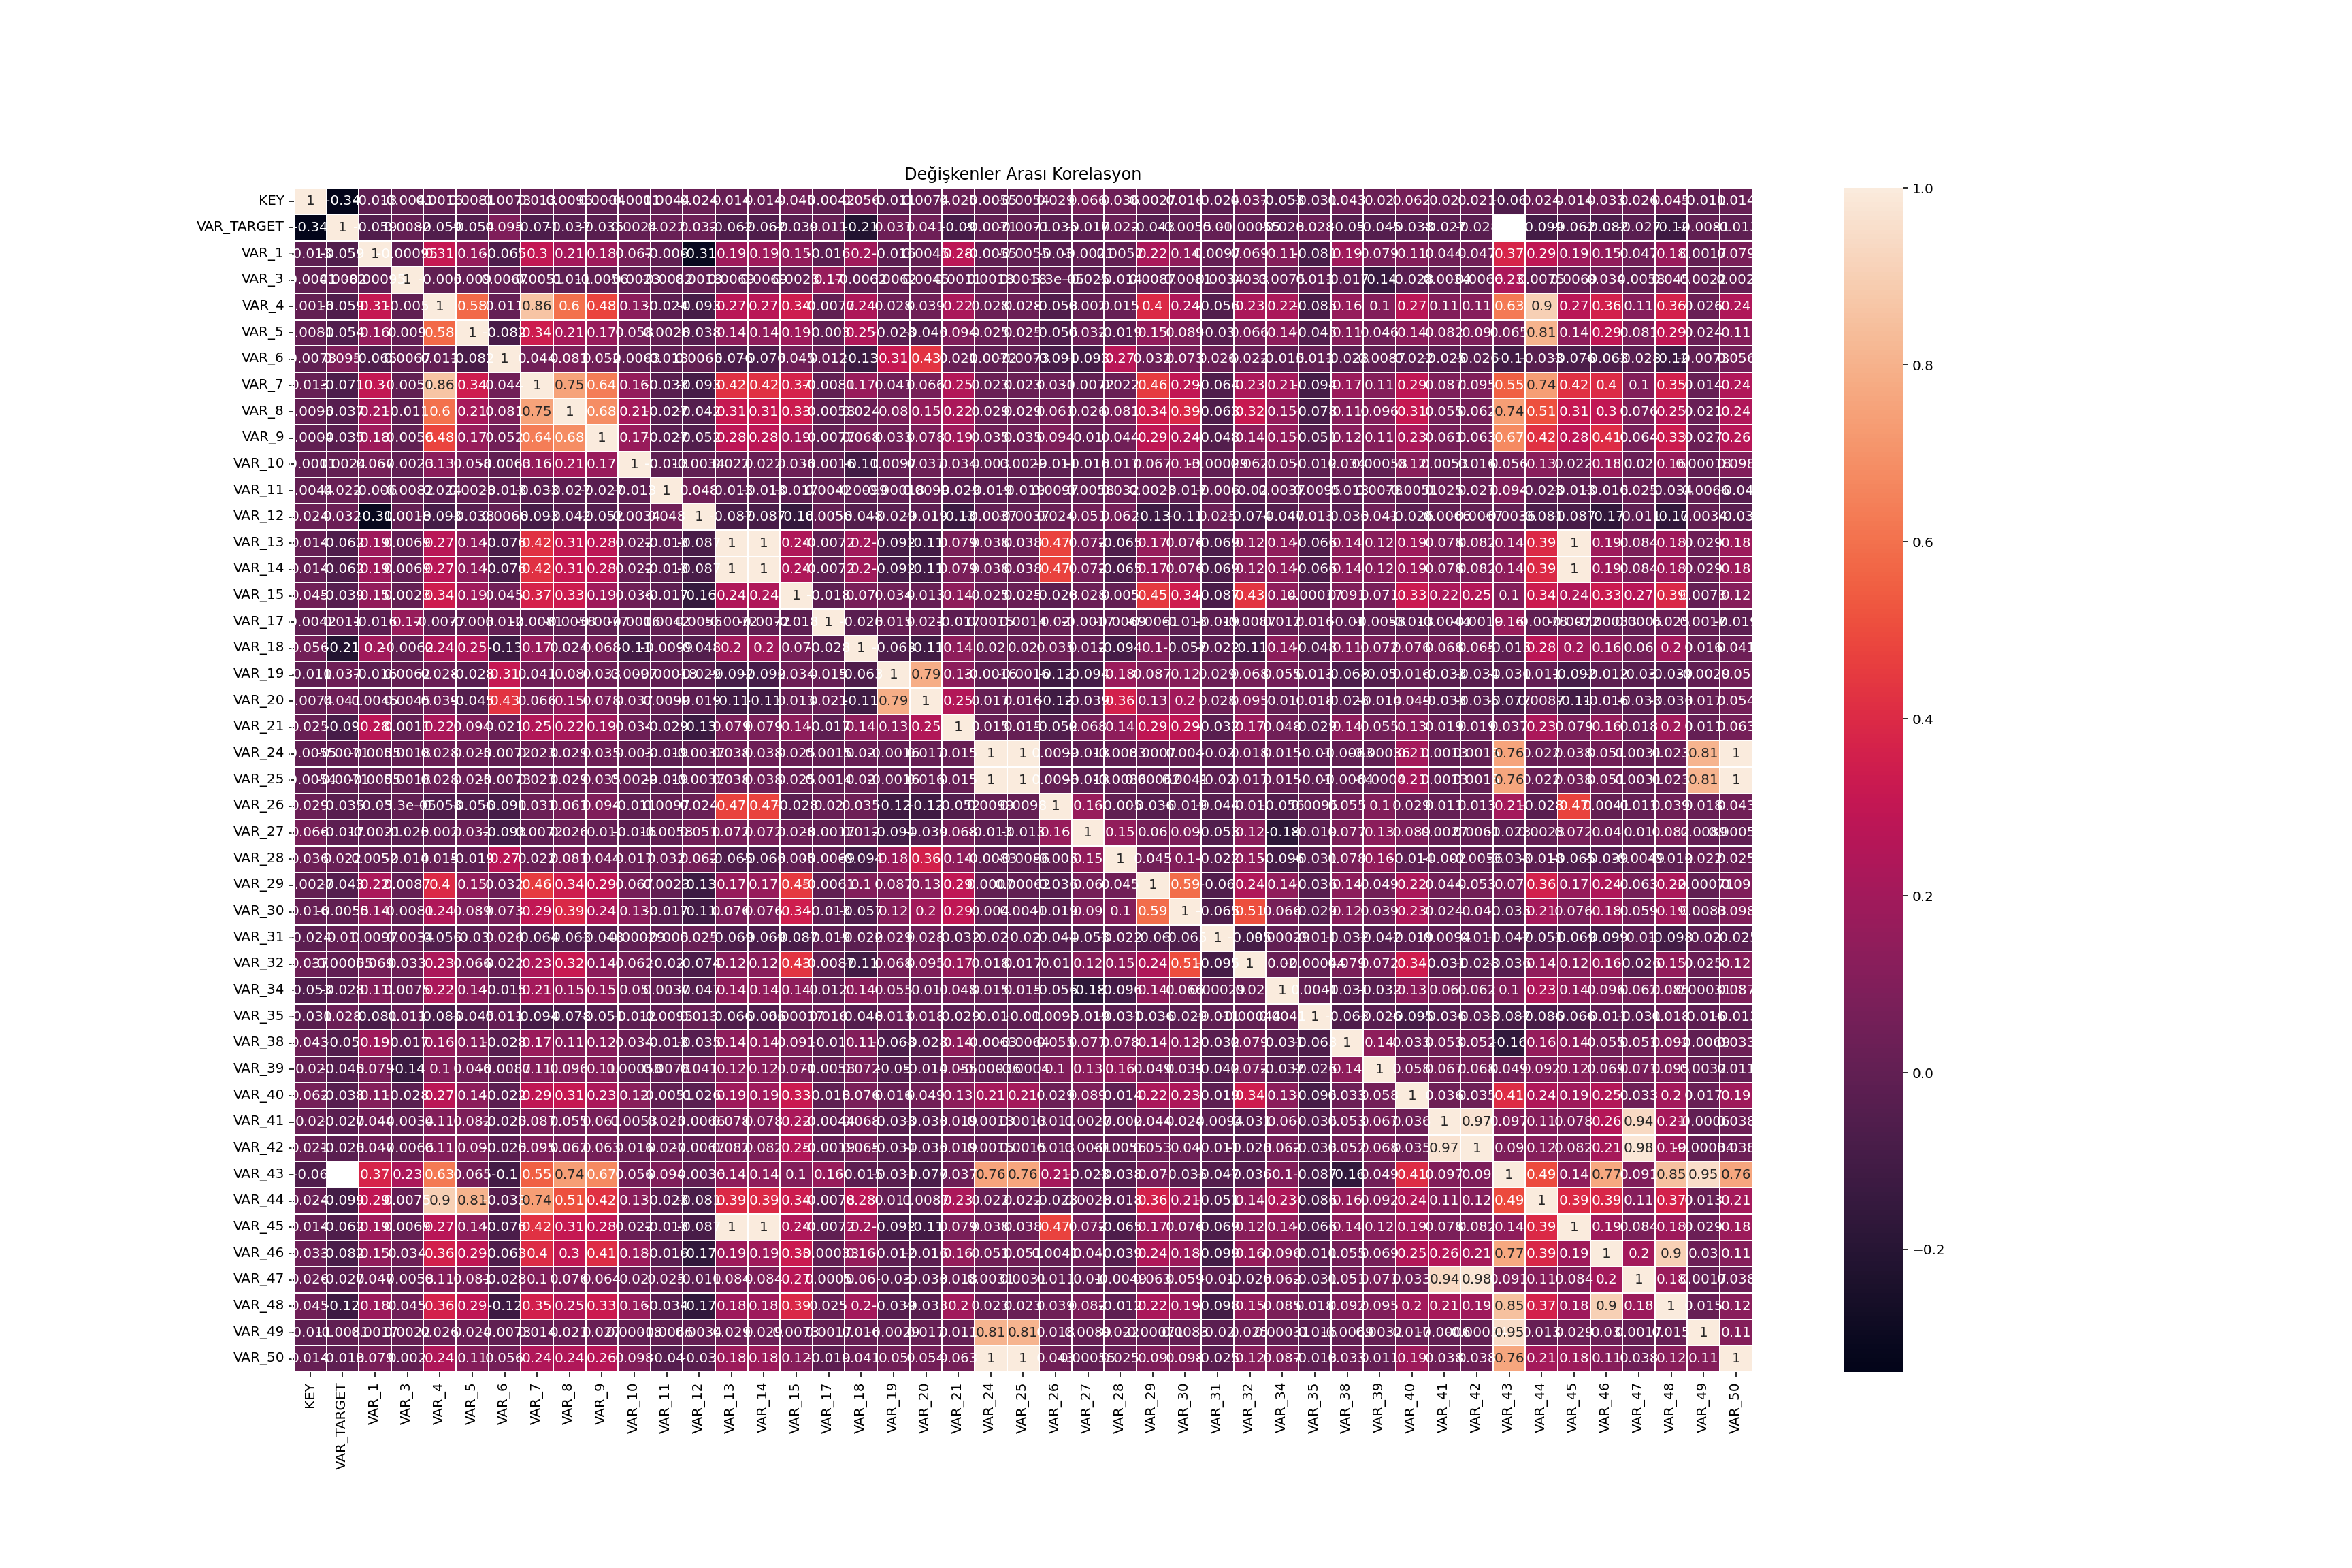

In [77]:
# heatmap
plt.figure(figsize = (24, 16))

corr = data.corr()

sns.heatmap(data = corr, annot = True, fmt = '.2g', linewidth = 1)
plt.title('Değişkenler Arası Korelasyon')
plt.show()

### Train-Test Split

In [78]:
# Veri kümesini X ve y olarak ayırma
X = data.drop(['VAR_TARGET','KEY'], axis=1)
y = data['VAR_TARGET']

# Veri kümesini train ve test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# X_train, eğitim veri kümesinin özelliklerini temsil eder
# X_test, test veri kümesinin özelliklerini temsil eder
# y_train, eğitim veri kümesinin hedef değişkenini temsil eder
# y_test, test veri kümesinin hedef değişkenini temsil eder


In [79]:
# Sınıf etiketinin bölünmesini kontrol ediyoruz
print("Veri kümesindeki toplam sahte işlem sayısı: ", np.sum(y))
print("Eğitim veri kümesindeki sahte işlem sayısı: ", np.sum(y_train))
print("Test veri kümesindeki sahte işlem sayısı: ", np.sum(y_test))

Veri kümesindeki toplam sahte işlem sayısı:  246
Eğitim veri kümesindeki sahte işlem sayısı:  197
Test veri kümesindeki sahte işlem sayısı:  49


### Base Model 

In [80]:
# Target Encoder oluşturma
encoder = ce.TargetEncoder()

# Kategorik sütunları belirleme
categorical_columns = ['VAR_2', 'VAR_16', 'VAR_22', 'VAR_23', 'VAR_33', 'VAR_36', 'VAR_37']

# Kategorik sütunları dönüştürme
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

for column in categorical_columns:
    X_train_encoded[column] = encoder.fit_transform(X_train[column], y_train)
    X_test_encoded[column] = encoder.transform(X_test[column])

# Model oluşturma ve eğitme
model = HistGradientBoostingClassifier(random_state=42)
model.fit(X_train_encoded, y_train)

# Tahminler yapma
y_pred = model.predict(X_test_encoded)

# Sınıf bazında recall değerlerini hesaplama
recall = recall_score(y_test, y_pred, average=None)
recall_0 = recall[0]
recall_1 = recall[1]

# Şartları kontrol etme
condition_1 = recall_0 / recall_1 <= 0.025
condition_2 = (recall_0 + recall_1) / 2 >= 0.75

# Sonuçları yazdırma
output = f"Sınıf 0 için Recall değeri: {recall_0}\n"
output += f"Sınıf 1 için Recall değeri: {recall_1}\n"
output += f"Şart 1 {'karşılanıyor' if condition_1 else 'karşılanmıyor'}, {recall_0 / recall_1} <= 0.025\n"
output += f"Şart 2 {'karşılanıyor' if condition_2 else 'karşılanmıyor'}, {(recall_0 + recall_1) / 2} >= 0.75\n"

print(output)

Sınıf 0 için Recall değeri: 0.9972144846796658
Sınıf 1 için Recall değeri: 0.10204081632653061
Şart 1 karşılanmıyor, 9.772701949860725 <= 0.025
Şart 2 karşılanmıyor, 0.5496276505030981 >= 0.75



In [81]:
xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(X_train_encoded, y_train)
pred = xgb_cl.predict(X_test_encoded)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1077
           1       0.45      0.10      0.17        49

    accuracy                           0.96      1126
   macro avg       0.71      0.55      0.57      1126
weighted avg       0.94      0.96      0.94      1126



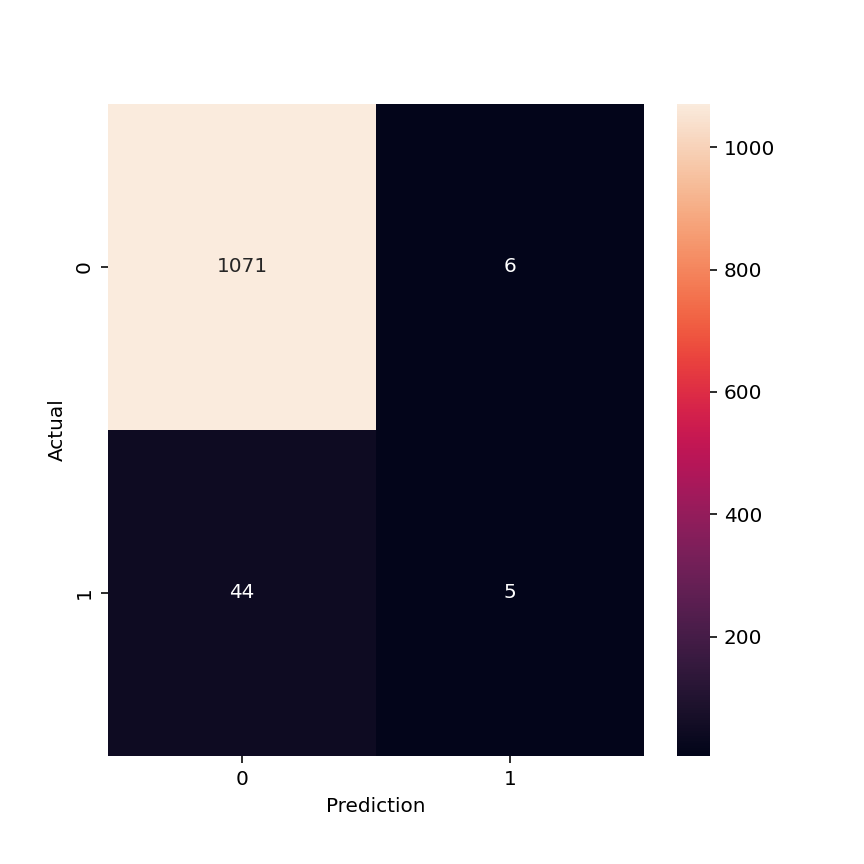

In [82]:
# Classification Evaluation Metrics
conf_matrix = confusion_matrix(y_test, pred)
print(classification_report(y_test, pred))
fig, ax =  plt.subplots(figsize = (6,6))
sns.heatmap(conf_matrix, annot=True, fmt= "d")
plt.ylabel("Actual")
plt.xlabel("Prediction")
plt.show()

### Missing Values

In [83]:
# missing values
data.isna().sum()

KEY              0
VAR_TARGET       0
VAR_1            0
VAR_2            0
VAR_3            4
VAR_4         1282
VAR_5         1282
VAR_6           14
VAR_7           14
VAR_8           14
VAR_9           14
VAR_10          14
VAR_11         310
VAR_12           0
VAR_13        1098
VAR_14        1098
VAR_15        3825
VAR_16          28
VAR_17         118
VAR_18          14
VAR_19          14
VAR_20          14
VAR_21          14
VAR_22         924
VAR_23          48
VAR_24           0
VAR_25           0
VAR_26        1349
VAR_27           0
VAR_28           0
VAR_29          14
VAR_30          14
VAR_31          11
VAR_32        3825
VAR_33        3825
VAR_34           0
VAR_35           5
VAR_36           0
VAR_37           0
VAR_38         179
VAR_39           0
VAR_40        4113
VAR_41           5
VAR_42           5
VAR_43        5592
VAR_44          14
VAR_45        1098
VAR_46        3812
VAR_47           5
VAR_48        3320
VAR_49           0
VAR_50        2264
dtype: int64

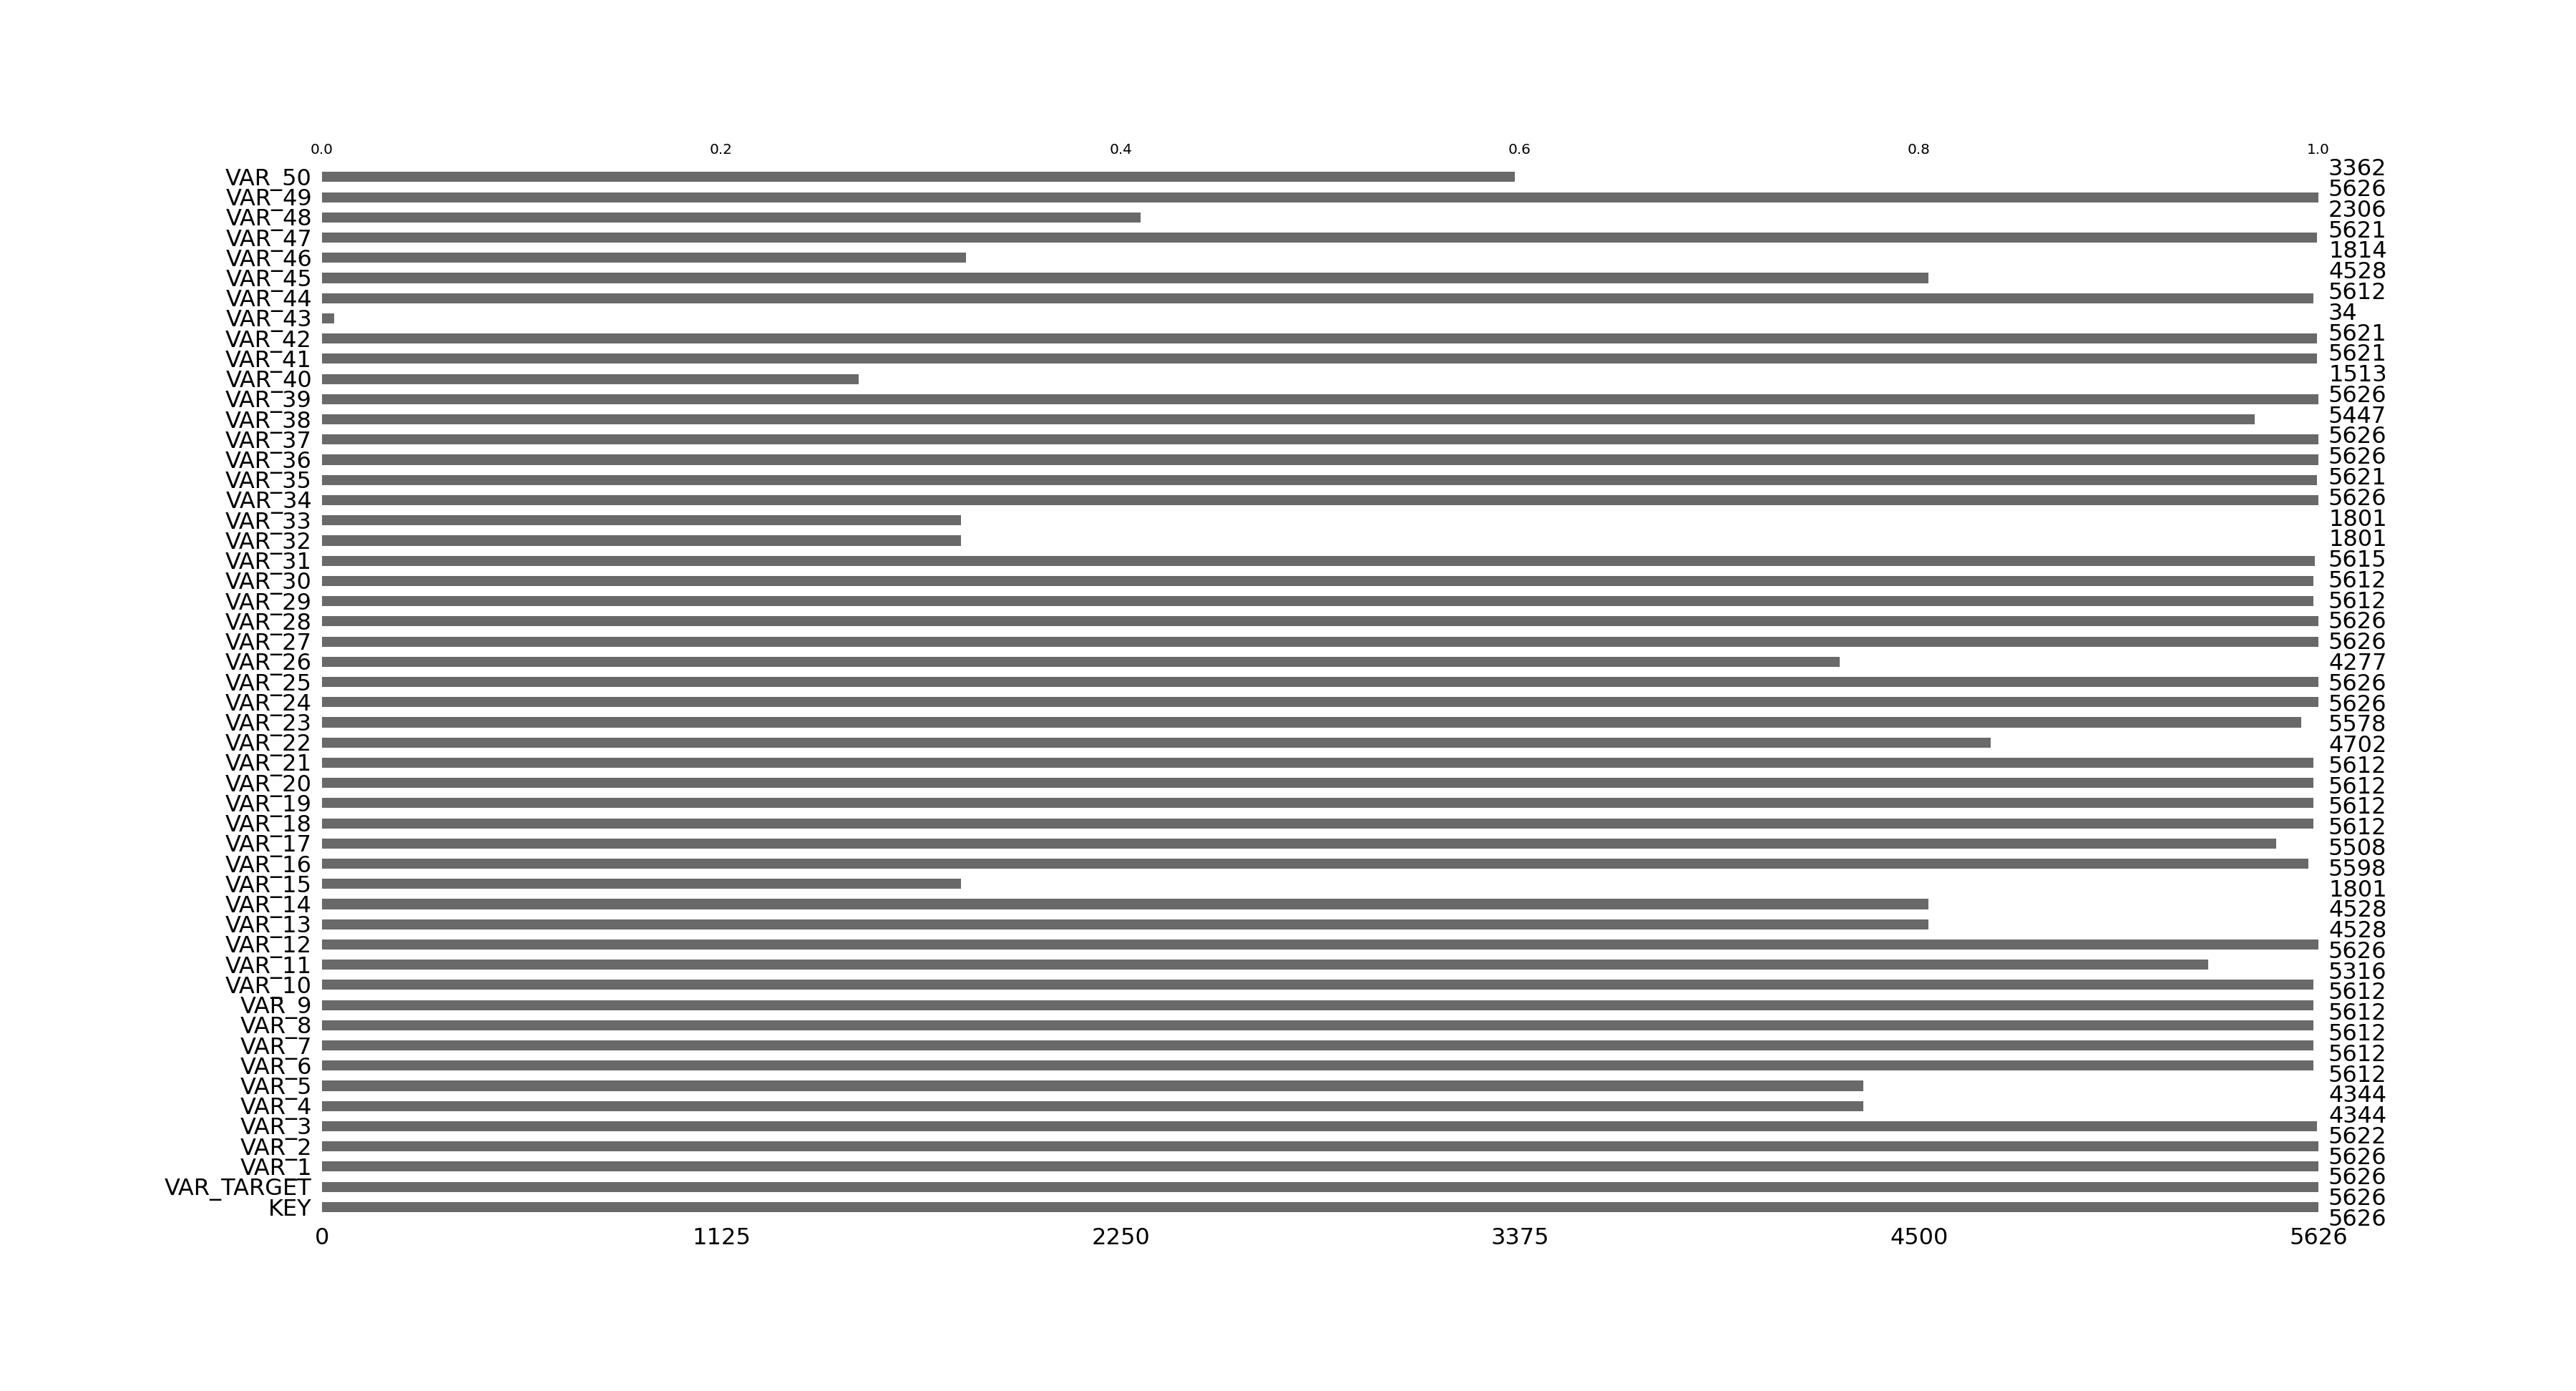

In [84]:
msno.bar(data)
plt.show()

In [85]:
# int columns
print("Int type values:",np.count_nonzero(X_test.select_dtypes('int').columns))
print(X_test.select_dtypes('int').columns)

Int type values: 9
Index(['VAR_1', 'VAR_12', 'VAR_24', 'VAR_25', 'VAR_27', 'VAR_28', 'VAR_34',
       'VAR_39', 'VAR_49'],
      dtype='object')


In [86]:
# float columns
print("Float64 type values:",np.count_nonzero(X_test.select_dtypes('float64').columns))
print(X_test.select_dtypes('float64').columns)

Float64 type values: 34
Index(['VAR_3', 'VAR_4', 'VAR_5', 'VAR_6', 'VAR_7', 'VAR_8', 'VAR_9', 'VAR_10',
       'VAR_11', 'VAR_13', 'VAR_14', 'VAR_15', 'VAR_17', 'VAR_18', 'VAR_19',
       'VAR_20', 'VAR_21', 'VAR_26', 'VAR_29', 'VAR_30', 'VAR_31', 'VAR_32',
       'VAR_35', 'VAR_38', 'VAR_40', 'VAR_41', 'VAR_42', 'VAR_43', 'VAR_44',
       'VAR_45', 'VAR_46', 'VAR_47', 'VAR_48', 'VAR_50'],
      dtype='object')


In [87]:
# object columns
print("Object type values:",np.count_nonzero(X_test.select_dtypes('object').columns))
print(X_test.select_dtypes('object').columns)

Object type values: 7
Index(['VAR_2', 'VAR_16', 'VAR_22', 'VAR_23', 'VAR_33', 'VAR_36', 'VAR_37'], dtype='object')


In [88]:
# VAR_16 sütunundaki eksik değerleri en sık tekrar eden değerle doldurun
most_frequent_value = X_train['VAR_16'].mode()[0]
X_train['VAR_16'].fillna(most_frequent_value, inplace=True)
X_test['VAR_16'].fillna(most_frequent_value, inplace=True)

# Diğer sütunlardaki eksik değerleri medyan değerleriyle doldurun
medians = X_train[['VAR_23', 'VAR_9', 'VAR_6', 'VAR_30', 'VAR_29', 'VAR_7', 'VAR_8', 'VAR_44', 'VAR_10', 'VAR_21', 'VAR_20', 'VAR_18', 'VAR_19', 'VAR_31', 'VAR_47', 'VAR_42', 'VAR_35', 'VAR_41', 'VAR_3','VAR_48']].median(numeric_only=True)
X_train.fillna(medians, inplace=True)
X_test.fillna(medians, inplace=True)


In [89]:
# VAR_36 sütununda "N" olan satırların VAR_46 sütunundaki eksik değerlerini 0 ile doldurun
X_train.loc[X_train["VAR_36"] == "N", "VAR_46"] = X_train.loc[X_train["VAR_36"] == "N", "VAR_46"].fillna(0)
median_value = X_train.loc[X_train["VAR_36"] == "Y", "VAR_46"].median()
X_train.loc[X_train["VAR_36"] == "Y", "VAR_46"] = X_train.loc[data["VAR_36"] == "Y", "VAR_46"].fillna(median_value)

X_test.loc[X_test["VAR_36"] == "N", "VAR_46"] = X_test.loc[X_test["VAR_36"] == "N", "VAR_46"].fillna(0)
median_value = X_train.loc[X_train["VAR_36"] == "Y", "VAR_46"].median()
X_test.loc[X_test["VAR_36"] == "Y", "VAR_46"] = X_test.loc[X_test["VAR_36"] == "Y", "VAR_46"].fillna(median_value)


#### Encoding

In [90]:
# Target Encoding işlemi için encoder oluşturma
encoder = ce.TargetEncoder()

# Nesne türündeki değişkenleri belirleme
object_columns = ['VAR_2', 'VAR_16', 'VAR_22', 'VAR_23', 'VAR_33', 'VAR_36', 'VAR_37']

# Nesne türündeki değişkenleri hedef değişkenle birlikte dönüştürme
for column in object_columns:
    X_train[column] = encoder.fit_transform(X_train[column], y_train)
    
for column in object_columns:
    X_test[column] = encoder.fit_transform(X_test[column], y_test)

In [91]:
# VAR_40 kolonunda VAR_27'deki 0 değerlerini 0 olarak doldurun
X_train.loc[X_train["VAR_27"] == 0, "VAR_40"] = 0
X_test.loc[X_test["VAR_27"] == 0, "VAR_40"] = 0

In [92]:
# VAR_32 kolonunda VAR_30'deki 0 değerlerini 0 olarak doldurun
X_train.loc[X_train["VAR_30"] == 0, "VAR_32"] = 0
X_test.loc[X_test["VAR_30"] == 0, "VAR_32"] = 0

In [93]:
# VAR_33 kolonunda VAR_32'deki 0 değerlerini 0 olarak doldurun. limit aşım borcu olan limit aşımı yapmıştır.
X_train.loc[X_train["VAR_32"] == 0, "VAR_33"] = 0
X_test.loc[X_test["VAR_32"] == 0, "VAR_33"] = 0

In [94]:
# VAR_46 sütunu boş olan ve VAR_47 sütunu "0.0" olan satırların VAR_46 sütununu 0 ile doldurun
X_train[(X_train["VAR_46"].isnull()) & (X_train["VAR_47"] == "0.0")] = X_train[(X_train["VAR_46"].isnull()) & (X_train["VAR_47"] == "0.0")].fillna(0)
X_test[(X_test["VAR_46"].isnull()) & (X_test["VAR_47"] == "0.0")] = X_test[(X_test["VAR_46"].isnull()) & (X_test["VAR_47"] == "0.0")].fillna(0)


In [95]:
# VAR_46 sütunu 0.0 olan satırların VAR_48 sütununu 0 ile doldurun
X_train.loc[X_train["VAR_46"] == 0.0, "VAR_48"] = X_train.loc[X_train["VAR_46"] == 0.0, "VAR_48"].fillna(0)
X_test.loc[X_test["VAR_46"] == 0.0, "VAR_48"] = X_test.loc[X_test["VAR_46"] == 0.0, "VAR_48"].fillna(0)


In [96]:
# VAR_17 sütunundaki eksik değerleri VAR_3 sütunundaki değerlerle doldurun
X_train['VAR_17'] = X_train.apply(lambda row: row['VAR_3'] if pd.isnull(row['VAR_17']) else row['VAR_17'], axis=1)
X_test['VAR_17'] = X_test.apply(lambda row: row['VAR_3'] if pd.isnull(row['VAR_17']) else row['VAR_17'], axis=1)


In [97]:
# açık kredi toplamı sıfırsa ve VAR_26 da nan ise onları sıfır ile doldurur
X_train.loc[X_train["VAR_40"] == 0.0, "VAR_26"] = X_train.loc[X_train["VAR_40"] == 0.0, "VAR_26"].fillna(0)
X_test.loc[X_test["VAR_40"] == 0.0, "VAR_26"] = X_test.loc[X_test["VAR_40"] == 0.0, "VAR_26"].fillna(0)

In [98]:
# VAR_27 sütunu 0.0 olan satırların VAR_26 sütununu 0 ile doldurun
X_train.loc[X_train["VAR_27"] == 0.0, "VAR_26"] = X_train.loc[X_train["VAR_27"] == 0.0, "VAR_26"].fillna(0)
X_test.loc[X_test["VAR_27"] == 0.0, "VAR_26"] = X_test.loc[X_test["VAR_27"] == 0.0, "VAR_26"].fillna(0)

In [99]:
# VAR_26 sütunundaki eksik değerleri moda göre doldurun
mode_value = X_train["VAR_26"].mode()[0]
X_train["VAR_26"].fillna(mode_value, inplace=True)
X_test["VAR_26"].fillna(mode_value, inplace=True)

In [100]:
X_train['VAR_40'].fillna(X_train['VAR_40'].median(), inplace=True)
X_test['VAR_40'].fillna(X_test['VAR_40'].median(), inplace=True)

In [101]:
# VAR_32, VAR_33, VAR_29 sütunları 0 olan ve VAR_15 sütunu boş olan satırların VAR_15 sütununu 0 ile doldurun
X_train.loc[(X_train['VAR_32'] == 0) & (X_train['VAR_33'] == 0) & (X_train['VAR_29'] == 0) & (X_train['VAR_15'].isnull()), 'VAR_15'] = 0
X_test.loc[(X_test['VAR_32'] == 0) & (X_test['VAR_33'] == 0) & (X_test['VAR_29'] == 0) & (X_test['VAR_15'].isnull()), 'VAR_15'] = 0

In [102]:
# Aktif kredi sayısı(VAR_26) == 0 ise mevcut kredi kartı limiti de(VAR_13) == 0 olmalı
X_train.loc[X_train["VAR_26"] == 0.0, "VAR_13"] = X_train.loc[X_train["VAR_26"] == 0.0, "VAR_13"].fillna(0)
X_test.loc[X_test["VAR_26"] == 0.0, "VAR_13"] = X_test.loc[X_test["VAR_26"] == 0.0, "VAR_13"].fillna(0)

In [103]:
# Droplama yapılacak sütunların listesi
columns_to_drop = data[['VAR_43','VAR_35','VAR_45','VAR_20','VAR_50','VAR_5', 'VAR_4','VAR_24','VAR_38','VAR_14','VAR_31','VAR_39','VAR_11','VAR_16','VAR_36']]  
X_train = X_train.drop(columns_to_drop, axis=1)
X_test = X_test.drop(columns_to_drop, axis=1)

In [104]:
X_train.columns

Index(['VAR_1', 'VAR_2', 'VAR_3', 'VAR_6', 'VAR_7', 'VAR_8', 'VAR_9', 'VAR_10',
       'VAR_12', 'VAR_13', 'VAR_15', 'VAR_17', 'VAR_18', 'VAR_19', 'VAR_21',
       'VAR_22', 'VAR_23', 'VAR_25', 'VAR_26', 'VAR_27', 'VAR_28', 'VAR_29',
       'VAR_30', 'VAR_32', 'VAR_33', 'VAR_34', 'VAR_37', 'VAR_40', 'VAR_41',
       'VAR_42', 'VAR_44', 'VAR_46', 'VAR_47', 'VAR_48', 'VAR_49'],
      dtype='object')

In [105]:
def fill_missing_values(data, target_variable, features):
    # Eğitim veri kümesi ve hedef değişken
    X = data[features].copy()
    y = data[target_variable].copy()
    
    # Sayısal değişkenleri doldurma
    numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
    numeric_imputer = SimpleImputer(strategy='mean')
    X[numeric_features] = numeric_imputer.fit_transform(X[numeric_features])
    return X

# 'VAR_15' ve 'VAR_32' değişkenlerini doldurma
filled_X_train_VAR_15 = fill_missing_values(X_train, 'VAR_15', ['VAR_29', 'VAR_32', 'VAR_7', 'VAR_30', 'VAR_44', 'VAR_8', 'VAR_46', 'VAR_40'])
filled_X_train_VAR_32 = fill_missing_values(X_train, 'VAR_32', ['VAR_30', 'VAR_15', 'VAR_40', 'VAR_8', 'VAR_33', 'VAR_27'])

filled_X_test_VAR_15 = fill_missing_values(X_test, 'VAR_15', ['VAR_29', 'VAR_32', 'VAR_7', 'VAR_30', 'VAR_44', 'VAR_8', 'VAR_46', 'VAR_40'])
filled_X_test_VAR_32 = fill_missing_values(X_test, 'VAR_32', ['VAR_30', 'VAR_15', 'VAR_40', 'VAR_8', 'VAR_33', 'VAR_27'])

# Doldurulmuş sütunları X_train ve X_test'e ekleme
X_train['VAR_15'] = filled_X_train_VAR_15.iloc[:, 0]
X_train['VAR_32'] = filled_X_train_VAR_32.iloc[:, 0]

X_test['VAR_15'] = filled_X_test_VAR_15.iloc[:, 0]
X_test['VAR_32'] = filled_X_test_VAR_32.iloc[:, 0]




### Target Analysis



In [106]:
classes = data['VAR_TARGET'].value_counts()
print(classes)

0    5380
1     246
Name: VAR_TARGET, dtype: int64


In [107]:
classes=data['VAR_TARGET'].value_counts()
normal_share=round(classes[0]/data['VAR_TARGET'].count()*100,2)
fraud_share=round(classes[1]/data['VAR_TARGET'].count()*100, 2)
print("Non-Fraud : {} %".format(normal_share))
print("    Fraud : {} %".format(fraud_share))

Non-Fraud : 95.63 %
    Fraud : 4.37 %


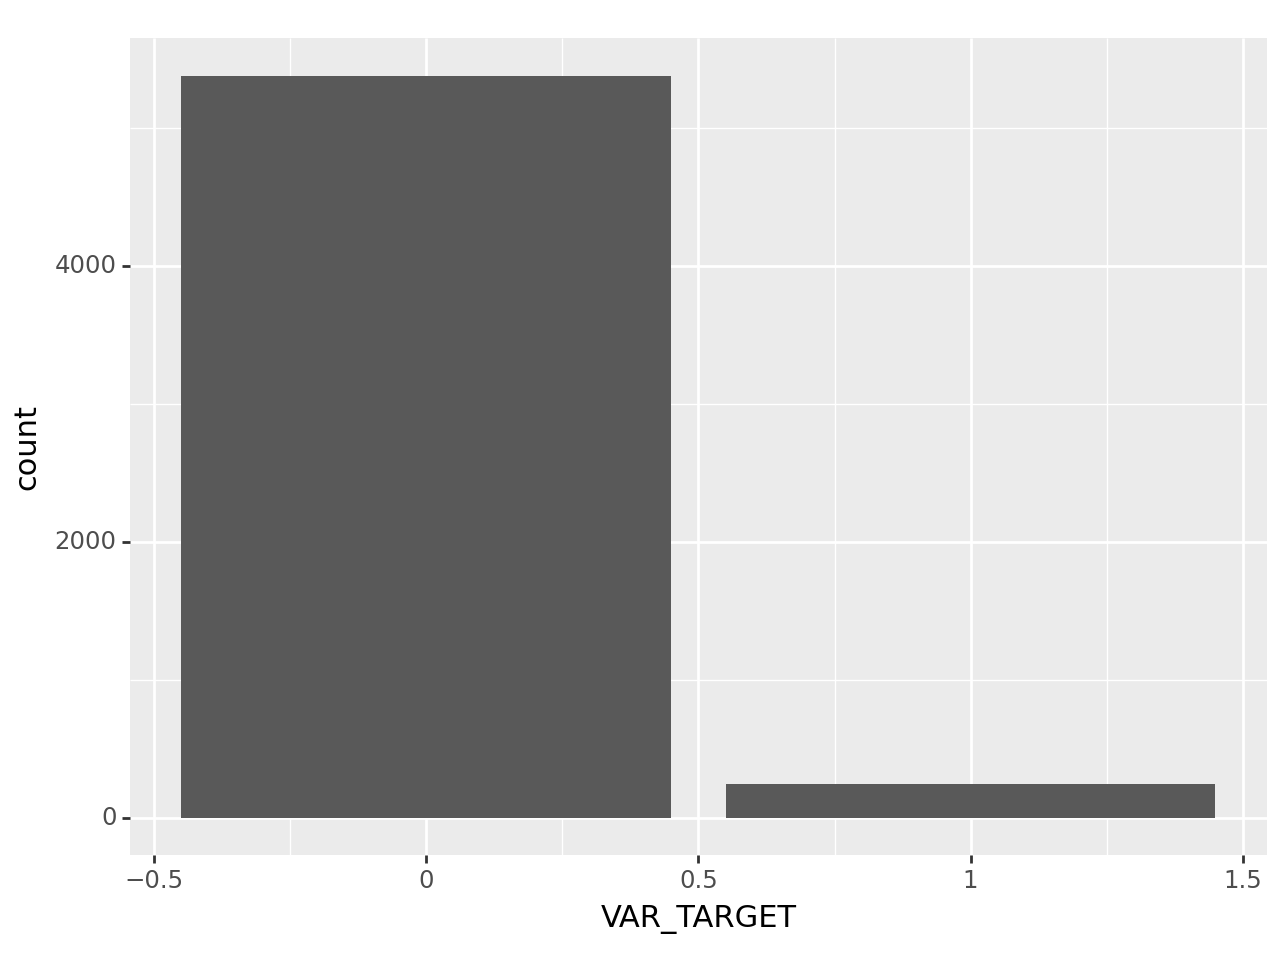

<Figure Size: (640 x 480)>

In [108]:
# VAR_TARGET sütununu y eksenine yerleştirerek çubuk grafiği oluşturma
ggplot(data, aes(x='VAR_TARGET')) + \
    geom_bar(stat='count')


### Outlier Detection

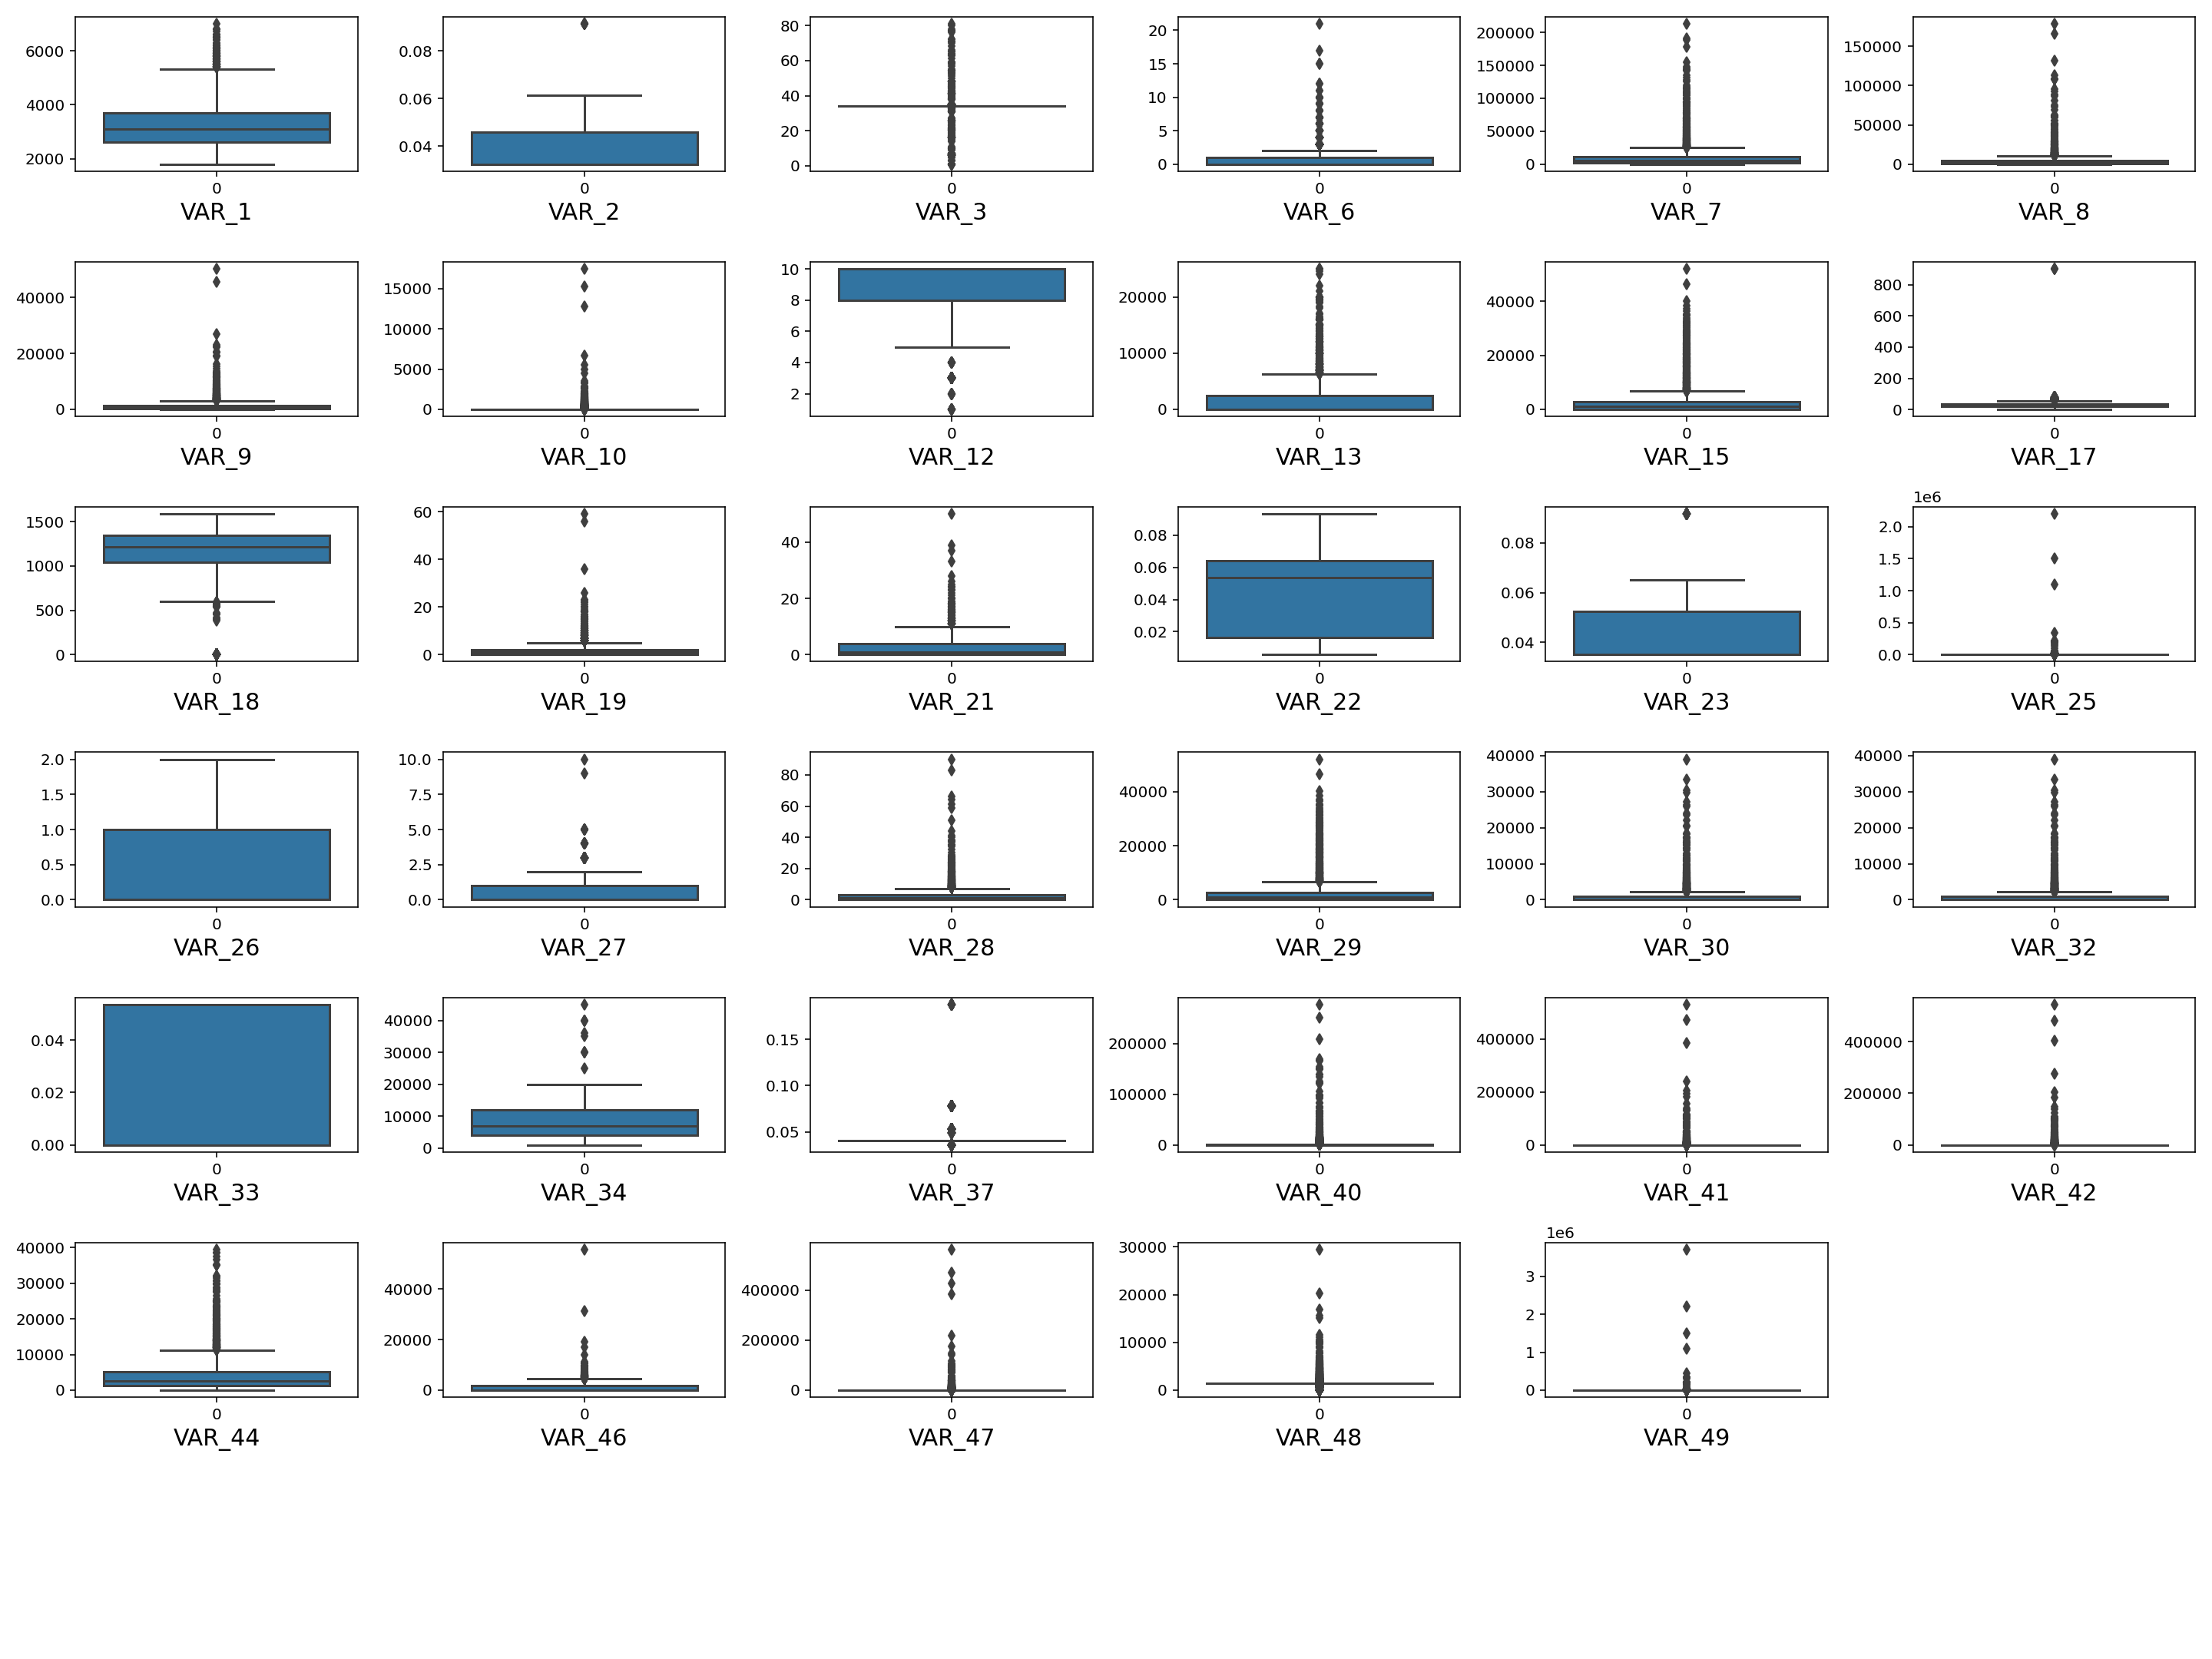

In [109]:
plt.figure(figsize = (20, 15))
plotnumber = 1

for col in X_train.columns:
    if plotnumber <= 40:
        ax = plt.subplot(7, 6, plotnumber)
        sns.boxplot(X_train[col])
        plt.xlabel(col, fontsize = 15)
    
    plotnumber += 1
plt.tight_layout()
plt.show()

In [110]:
X_train.isnull().sum()

VAR_1     0
VAR_2     0
VAR_3     0
VAR_6     0
VAR_7     0
VAR_8     0
VAR_9     0
VAR_10    0
VAR_12    0
VAR_13    0
VAR_15    0
VAR_17    0
VAR_18    0
VAR_19    0
VAR_21    0
VAR_22    0
VAR_23    0
VAR_25    0
VAR_26    0
VAR_27    0
VAR_28    0
VAR_29    0
VAR_30    0
VAR_32    0
VAR_33    0
VAR_34    0
VAR_37    0
VAR_40    0
VAR_41    0
VAR_42    0
VAR_44    0
VAR_46    0
VAR_47    0
VAR_48    0
VAR_49    0
dtype: int64

### Scaling

In [111]:
# Sayısal sütunları seçme ve X_train'de ölçekleme
numeric_columns = X_train.select_dtypes(include='number').columns
X_train_numeric = X_train[numeric_columns]

# Ölçekleyiciyi oluşturma ve X_train'de uygulama
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)

# X_train'deki ölçeklenmiş sayısal verilerin yazdırılması
scaled_X_train = pd.DataFrame(data=X_train_scaled, columns=X_train_numeric.columns)
#print("Scaled X_train:")
#print(scaled_X_train.head())

# X_test'te ölçekleme
X_test_numeric = X_test[numeric_columns]
X_test_scaled = scaler.transform(X_test_numeric)

# X_test'teki ölçeklenmiş sayısal verilerin yazdırılması
scaled_X_test = pd.DataFrame(data=X_test_scaled, columns=X_test_numeric.columns)
#print("\nScaled X_test:")
#print(scaled_X_test.head())


### Oversampling 

Model Accuracy: 0.9298401420959147
Confusion Matrix:
 [[1038   39]
 [  40    9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      1077
           1       0.19      0.18      0.19        49

    accuracy                           0.93      1126
   macro avg       0.58      0.57      0.57      1126
weighted avg       0.93      0.93      0.93      1126



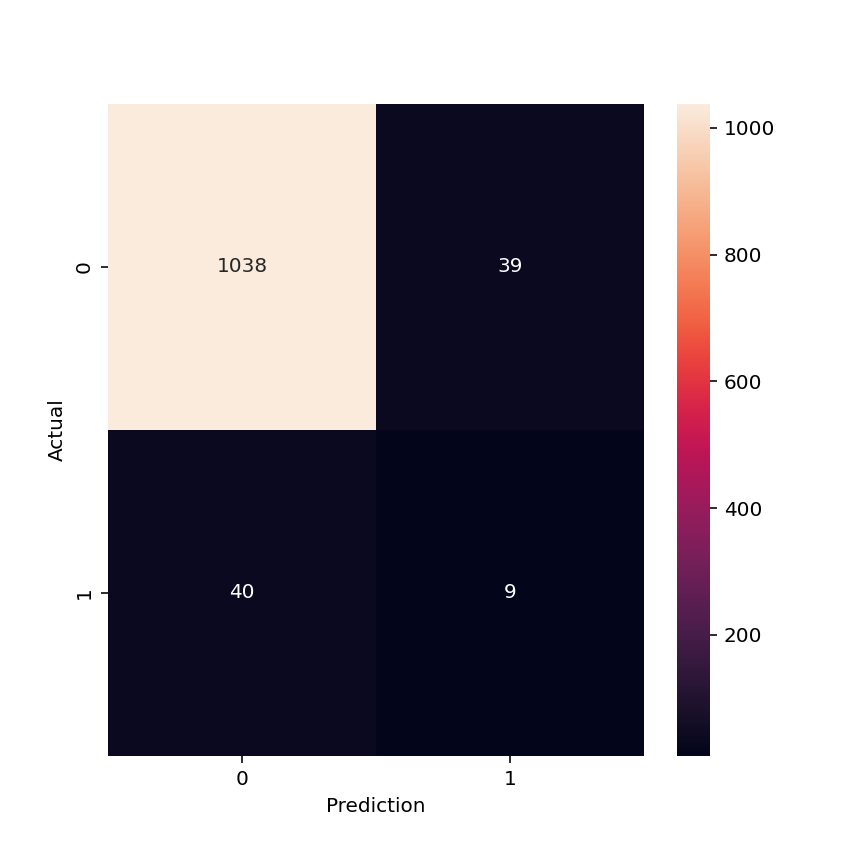

In [112]:
oversampler = SMOTE(random_state=42)

# Eğitim verilerini tekrarlayarak (oversampling) dengeli bir veri kümesi oluşturalım
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Modeli oluşturalım ve eğitelim (Random Forest Classifier kullanalım)
model = RandomForestClassifier()
model.fit(X_train_resampled, y_train_resampled)

# Test verileri üzerinde tahmin yapalım
y_pred = model.predict(X_test)

# Modelin performansını değerlendirelim
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Model Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

# Confusion Matrix'i görselleştirelim
fig, ax =  plt.subplots(figsize = (6,6))
sns.heatmap(conf_matrix, annot=True, fmt= "d")
plt.ylabel("Actual")
plt.xlabel("Prediction")
plt.show()

### Models

In [113]:
# SVC modelini oluşturma ve eğitme
svc = SVC()
svc.fit(X_train, y_train)

# Test verileri üzerinde tahmin yapma
y_pred = svc.predict(X_test)

# Doğruluk skoru, karışıklık matrisi ve sınıflandırma raporu
svc_train_acc = accuracy_score(y_train, svc.predict(X_train))
svc_test_acc = accuracy_score(y_test, y_pred)

print(f"Eğitim doğruluk skoru (Support Vector Classifier): {svc_train_acc}")
print(f"Test doğruluk skoru (Support Vector Classifier): {svc_test_acc}")

class_report = classification_report(y_test, y_pred, zero_division=1)
print("Sınıflandırma Raporu:")
print(class_report)

Eğitim doğruluk skoru (Support Vector Classifier): 0.9562222222222222
Test doğruluk skoru (Support Vector Classifier): 0.9564831261101243
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1077
           1       1.00      0.00      0.00        49

    accuracy                           0.96      1126
   macro avg       0.98      0.50      0.49      1126
weighted avg       0.96      0.96      0.94      1126



In [114]:
# Karar ağacı sınıflandırıcısı oluşturma
dtc = DecisionTreeClassifier()

# AdaBoost sınıflandırıcısı oluşturma ve parametrelerini belirleme
ada = AdaBoostClassifier(base_estimator=dtc)

parameters = {
    'n_estimators': [50, 70, 90, 120, 180, 200],
    'learning_rate': [0.001, 0.01, 0.1, 1, 10],
    'algorithm': ['SAMME', 'SAMME.R']
}

# GridSearchCV ile parametre optimizasyonu yapma
grid_search = GridSearchCV(ada, parameters, n_jobs=-1, cv=5, verbose=1)
grid_search.fit(X_train
                , y_train)


Fitting 5 folds for each of 60 candidates, totalling 300 fits


C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier()),
             n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.001, 0.01, 0.1, 1, 10],
                         'n_estimators': [50, 70, 90, 120, 180, 200]},
             verbose=1)

In [116]:
# best parameter and best score
print(grid_search.best_params_)
print(grid_search.best_score_)

{'algorithm': 'SAMME.R', 'learning_rate': 0.001, 'n_estimators': 200}
0.920888888888889


In [117]:
# best estimator 
ada = grid_search.best_estimator_
y_pred = ada.predict(X_test)

In [118]:
# accuracy_score, confusion_matrix and classification_report
ada_train_acc = accuracy_score(y_train, ada.predict(X_train))
ada_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of Ada Boost is : {ada_train_acc}")
print(f"Test accuracy of Ada Boost is : {ada_test_acc}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy of Ada Boost is : 1.0
Test accuracy of Ada Boost is : 0.91651865008881
[[1023   54]
 [  40    9]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1077
           1       0.14      0.18      0.16        49

    accuracy                           0.92      1126
   macro avg       0.55      0.57      0.56      1126
weighted avg       0.93      0.92      0.92      1126



In [119]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)

# accuracy_score, confusion_matrix and classification_report

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

dtc_train_acc = accuracy_score(y_train, dtc.predict(X_train))
dtc_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of Decision Tree is : {dtc_train_acc}")
print(f"Test accuracy of Decision Tree is : {dtc_test_acc}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# hyper parameter tuning

from sklearn.model_selection import GridSearchCV

grid_params = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [3, 5, 7, 10],
    'min_samples_split' : range(2, 10, 1),
    'min_samples_leaf' : range(2, 10, 1)
}

grid_search = GridSearchCV(dtc, grid_params, cv = 5, n_jobs = -1, verbose = 1)
grid_search.fit(X_train, y_train)

Training accuracy of Decision Tree is : 1.0
Test accuracy of Decision Tree is : 0.91651865008881
[[1023   54]
 [  40    9]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1077
           1       0.14      0.18      0.16        49

    accuracy                           0.92      1126
   macro avg       0.55      0.57      0.56      1126
weighted avg       0.93      0.92      0.92      1126

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': range(2, 10),
                         'min_samples_split': range(2, 10)},
             verbose=1)

In [120]:
# best parameters and best score
print(grid_search.best_params_)
print(grid_search.best_score_)

{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.9562222222222223


In [121]:
# best estimator 
dtc = grid_search.best_estimator_
y_pred = dtc.predict(X_test)

In [122]:
# accuracy_score, confusion_matrix and classification_report
dtc_train_acc = accuracy_score(y_train, dtc.predict(X_train))
dtc_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of Decision Tree is : {dtc_train_acc}")
print(f"Test accuracy of Decision Tree is : {dtc_test_acc}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy of Decision Tree is : 0.9562222222222222
Test accuracy of Decision Tree is : 0.9564831261101243
[[1077    0]
 [  49    0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1077
           1       0.00      0.00      0.00        49

    accuracy                           0.96      1126
   macro avg       0.48      0.50      0.49      1126
weighted avg       0.91      0.96      0.94      1126



C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [123]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

In [124]:
# accuracy_score, confusion_matrix and classification_report
xgb_train_acc = accuracy_score(y_train, xgb.predict(X_train))
xgb_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of XgBoost is : {xgb_train_acc}")
print(f"Test accuracy of XgBoost is : {xgb_test_acc}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy of XgBoost is : 1.0
Test accuracy of XgBoost is : 0.9547069271758437
[[1067   10]
 [  41    8]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1077
           1       0.44      0.16      0.24        49

    accuracy                           0.95      1126
   macro avg       0.70      0.58      0.61      1126
weighted avg       0.94      0.95      0.94      1126



In [125]:
param_grid = {"n_estimators": [10, 50, 100, 130], "criterion": ['gini', 'entropy'],
                               "max_depth": range(2, 10, 1)}

grid = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5,  verbose=3,n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 512 candidates, totalling 2560 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 10],
                         'min_samples_leaf': range(2, 10),
                         'min_samples_split': range(2, 10)},
             verbose=1)

In [126]:
# best estimator 
xgb = grid_search.best_estimator_
y_pred = xgb.predict(X_test)

In [127]:
# accuracy_score, confusion_matrix and classification_report
xgb_train_acc = accuracy_score(y_train, xgb.predict(X_train))
xgb_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of XgBoost is : {xgb_train_acc}")
print(f"Test accuracy of XgBoost is : {xgb_test_acc}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy of XgBoost is : 0.9562222222222222
Test accuracy of XgBoost is : 0.9564831261101243
[[1077    0]
 [  49    0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1077
           1       0.00      0.00      0.00        49

    accuracy                           0.96      1126
   macro avg       0.48      0.50      0.49      1126
weighted avg       0.91      0.96      0.94      1126



C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
C:\Users\lenovo\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


### SMOTE

In [128]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Yeni veri setinin boyutunu kontrol edelim
print("Yeni eğitim veri kümesi boyutu:", X_train_resampled.shape, y_train_resampled.shape)

# XGBoost modelini kullanarak yeniden örnekleme yapılmış eğitim verilerini kullanarak modeli eğitebilirsiniz
xgb_with_smote = XGBClassifier()
xgb_with_smote.fit(X_train_resampled, y_train_resampled)

# Test verileri üzerinde tahmin yapma
y_pred_with_smote = xgb_with_smote.predict(X_test)

# Model performansını değerlendirelim
xgb_train_acc_with_smote = accuracy_score(y_train_resampled, xgb_with_smote.predict(X_train_resampled))
xgb_test_acc_with_smote = accuracy_score(y_test, y_pred_with_smote)

print(f"Eğitim doğruluk skoru (XGBoost ile SMOTE): {xgb_train_acc_with_smote}")
print(f"Test doğruluk skoru (XGBoost ile SMOTE): {xgb_test_acc_with_smote}")

print("Karışıklık Matrisi (XGBoost ile SMOTE):")
print(confusion_matrix(y_test, y_pred_with_smote))

print("Sınıflandırma Raporu (XGBoost ile SMOTE):")
print(classification_report(y_test, y_pred_with_smote))


Yeni eğitim veri kümesi boyutu: (8606, 35) (8606,)
Eğitim doğruluk skoru (XGBoost ile SMOTE): 1.0
Test doğruluk skoru (XGBoost ile SMOTE): 0.7992895204262878
Karışıklık Matrisi (XGBoost ile SMOTE):
[[875 202]
 [ 24  25]]
Sınıflandırma Raporu (XGBoost ile SMOTE):
              precision    recall  f1-score   support

           0       0.97      0.81      0.89      1077
           1       0.11      0.51      0.18        49

    accuracy                           0.80      1126
   macro avg       0.54      0.66      0.53      1126
weighted avg       0.94      0.80      0.85      1126



---- XGBoost Modeli ----
Eğitim doğruluk skoru: 0.9562
Test doğruluk skoru: 0.9565
ROC-AUC skoru: 0.7459
Karışıklık Matrisi:
[[1038   39]
 [  40    9]]
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      1077
           1       0.19      0.18      0.19        49

    accuracy                           0.93      1126
   macro avg       0.58      0.57      0.57      1126
weighted avg       0.93      0.93      0.93      1126



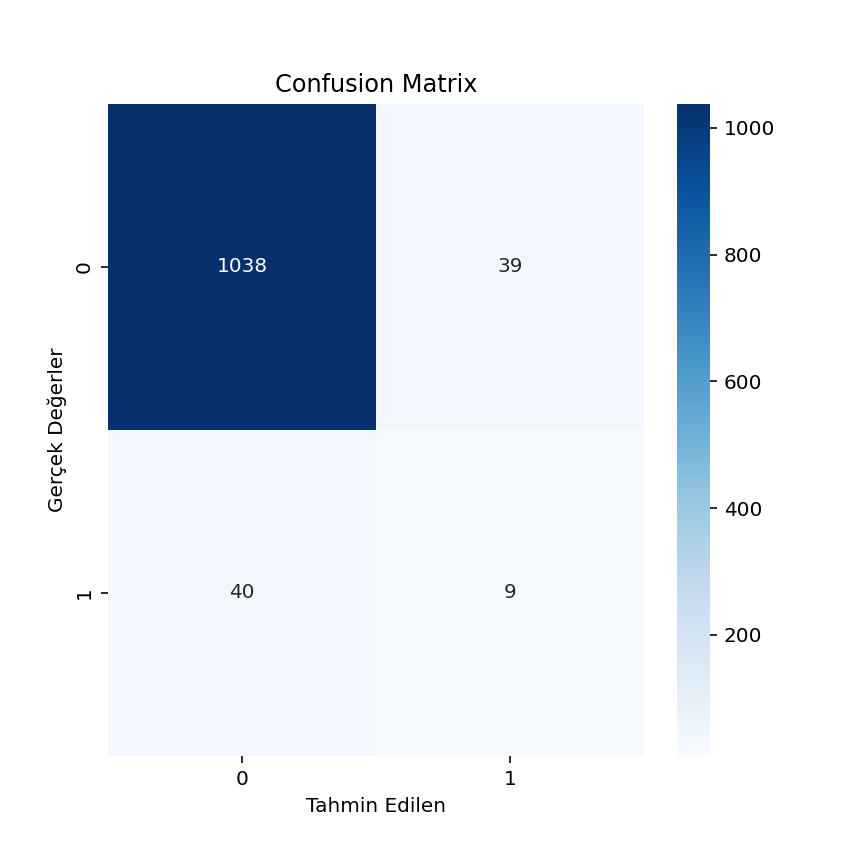

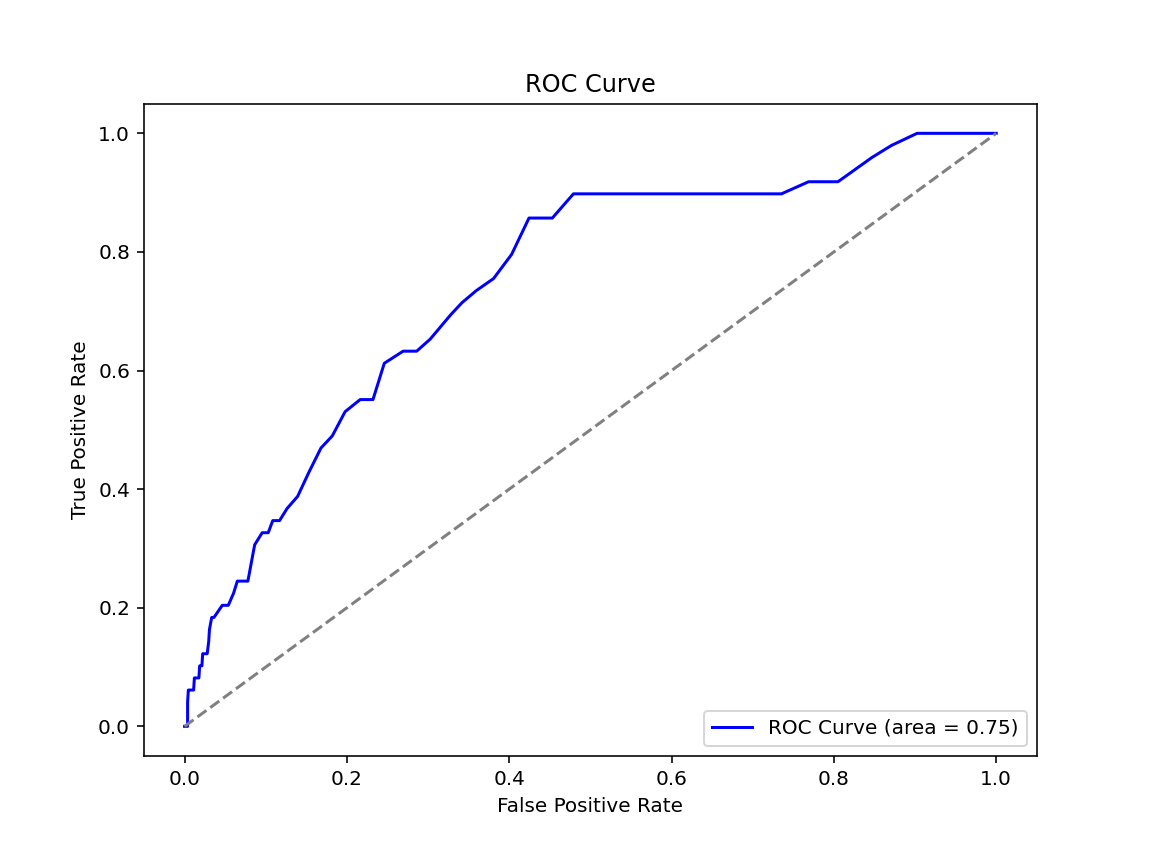

In [129]:
# XGBoost modeli için değerlendirme metrikleri
print("---- XGBoost Modeli ----")
print(f"Eğitim doğruluk skoru: {xgb_train_acc:.4f}")
print(f"Test doğruluk skoru: {xgb_test_acc:.4f}")

# Test verileri üzerinde tahmin yapma
y_pred = model.predict(X_test)

# ROC-AUC skoru
y_pred_prob = model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_prob[:, 1])
print(f"ROC-AUC skoru: {roc_auc:.4f}")

# Karışıklık Matrisi
conf_matrix = confusion_matrix(y_test, y_pred)
print("Karışıklık Matrisi:")
print(conf_matrix)

# Sınıflandırma Raporu
print("Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Confusion Matrix görselleştirme
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Değerler')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve görselleştirme
fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


---- SMOTE Sonrası XGBoost Modeli ----
Eğitim doğruluk skoru (SMOTE Sonrası): 1.0000
Test doğruluk skoru (SMOTE Sonrası): 0.7993
ROC-AUC skoru (SMOTE Sonrası): 0.7687
Karışıklık Matrisi:
[[875 202]
 [ 24  25]]
Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.97      0.81      0.89      1077
           1       0.11      0.51      0.18        49

    accuracy                           0.80      1126
   macro avg       0.54      0.66      0.53      1126
weighted avg       0.94      0.80      0.85      1126



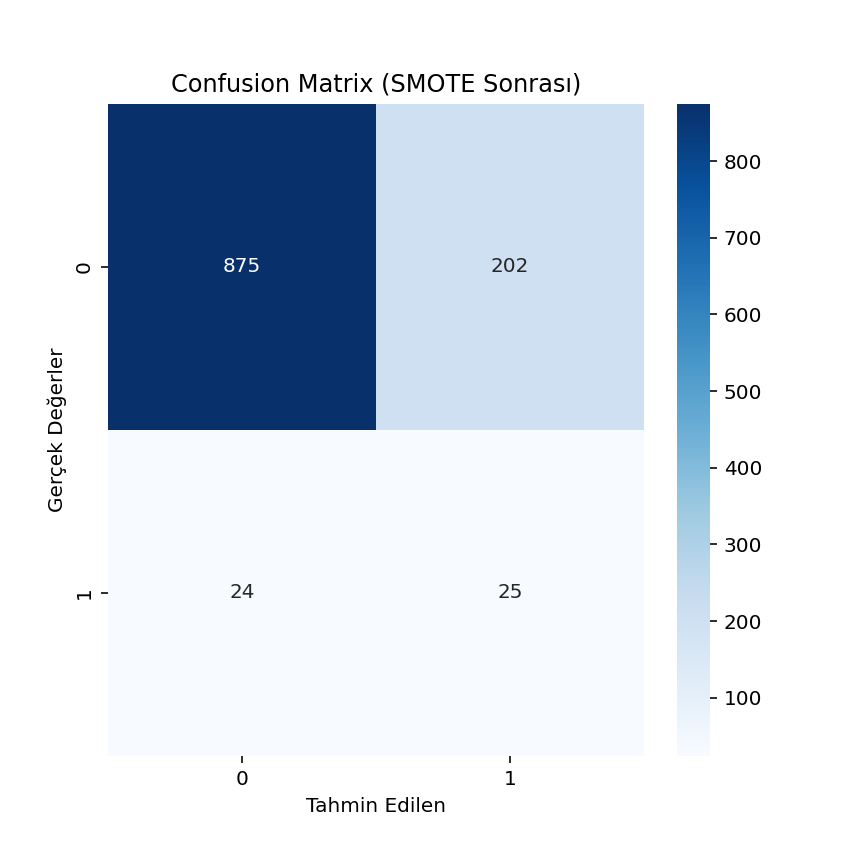

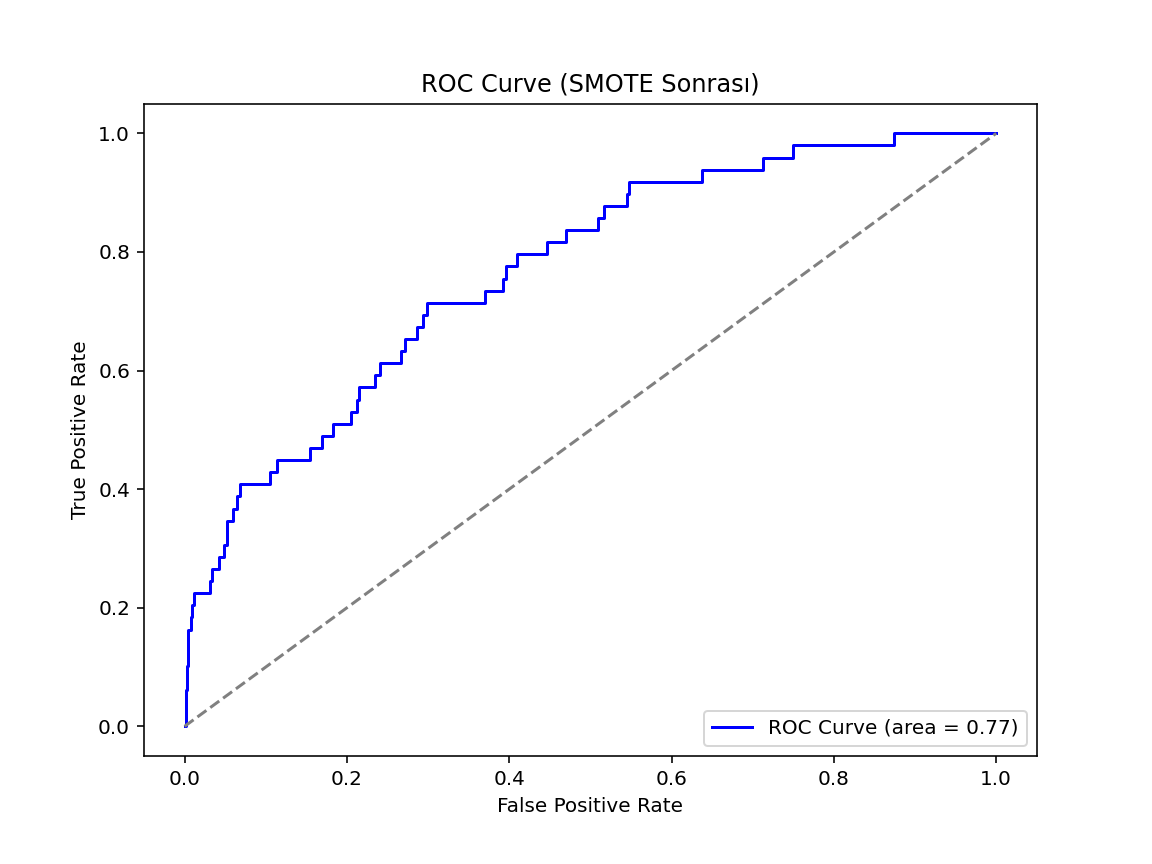

In [130]:
# SMOTE ile dengelenmiş veri kümesi oluşturma
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# XGBoost modeli için değerlendirme metrikleri
print("---- SMOTE Sonrası XGBoost Modeli ----")
xgb = XGBClassifier()
xgb.fit(X_train_smote, y_train_smote)

y_pred = xgb.predict(X_test)
xgb_train_acc = accuracy_score(y_train_smote, xgb.predict(X_train_smote))
xgb_test_acc = accuracy_score(y_test, y_pred)
y_pred_prob = xgb.predict_proba(X_test)[:, 1]

print(f"Eğitim doğruluk skoru (SMOTE Sonrası): {xgb_train_acc:.4f}")
print(f"Test doğruluk skoru (SMOTE Sonrası): {xgb_test_acc:.4f}")
print(f"ROC-AUC skoru (SMOTE Sonrası): {roc_auc_score(y_test, y_pred_prob):.4f}")

print("Karışıklık Matrisi:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

print("Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

# Confusion Matrix görselleştirme
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Değerler')
plt.title('Confusion Matrix (SMOTE Sonrası)')
plt.show()

# ROC Curve görselleştirme
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = %0.2f)' % roc_auc_score(y_test, y_pred_prob))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (SMOTE Sonrası)')
plt.legend(loc='lower right')
plt.show()


In [132]:
# Test verileri üzerinde tahmin yapma
y_pred = xgb.predict(X_test)

# Sınıf bazında recall değerlerini hesaplama
recall = recall_score(y_test, y_pred, average=None)
recall_0 = recall[0]
recall_1 = recall[1]

# Şartları kontrol etme
condition_1 = recall_0 / recall_1 <= 0.025
condition_2 = (recall_0 + recall_1) / 2 >= 0.75

print("Sınıf 0 için Recall:", recall_0)
print("Sınıf 1 için Recall:", recall_1)

if condition_1 and condition_2:
    print("Model, sınıflandırma görevini başarıyla yerine getiriyor.")
else:
    print("Modelin sınıflandırma performansı iyileştirilmeli.")


Sınıf 0 için Recall: 0.8124419684308264
Sınıf 1 için Recall: 0.5102040816326531
Modelin sınıflandırma performansı iyileştirilmeli.
